In [1]:
from numpy import random
import numpy as np
import pandas as pd

def draw_card(absolute=False):
    val = random.choice(10) + 1
    col = 1 if absolute else random.choice([-1,1], p=[1/3, 2/3])
    return col * val
    

def step(s,a):
    d = s[0]
    p = s[1]
    
    if p > 21 or p < 1: #player busted
        return s, -1, True
    
    if a == 'hit':
        s1 = p + draw_card()
        return (d, s1), 0, (s1 > 21 or s1 < 1)
    else: #a == 'stick'
        while d < 17 and d > 1:
            d += draw_card()
        if d > 21 or d < 1: #dealer busted
            return (d,p), 1, True
        elif d < p:
            return (d,p), 1, True
        elif d == p:
            return (d,p), 0, True
        else: # d > p
            return (d,p), -1, True
        

In [2]:
s = (draw_card(absolute=True),draw_card(absolute=True))
a = 'hit'
for i in range(0,5):
    s, r, ts = step(s,a)
    print(s,r)
    if ts:
        break

(9, 16) 0
(9, 22) 0


In [3]:
def get_episode(q, pi, n):
    try:
        episode = []
        s = (draw_card(absolute=True), draw_card(absolute=True))
        episode.append(s)
        while True:
            a = pi(q, s, ['hit', 'stick'], n)
            s, r, ts = step(s,a)
            episode.extend([a,r, s])
            if ts:
                return episode    
    except Exception as e:
        print("get_episode:", episode)
        print("get_episode:", s,r,ts)
        raise e

In [4]:
def glie_policy(q, s, a, n):
    s0,s1 = s[0]-1, s[1] - 1 # map state to indices
    try:
        a_idx = np.argmax(q[s0][s1])
        epsilon = 100 / (100 + np.sum(n[s0][s1]))
        a_prob = [epsilon/len(a)] * len(a)
        a_prob[a_idx] += 1 - epsilon
        return random.choice(a, p=a_prob)
    except Exception as e:
        print("glie:", s)
        raise e

In [5]:
q = np.zeros((10,21,2))
n = np.zeros((10,21,2))

In [6]:
gamma = 1
for k in range(0,1000000):
    try:
        g = np.zeros((10,21))
        r = 0
        e = get_episode(q, glie_policy, n)
        e.pop()
        e_reverse = e[::-1]
        for idx, x in enumerate(e_reverse[::3]):
            r = x + gamma * r
            s = e_reverse[idx*3 + 2]
            a = 0 if e_reverse[idx*3 + 1] == 'hit' else 1
            
            s0, s1 = s[0]-1, s[1]-1 #map state to indices
            if s1 >= len(g[0]):
                continue
                
            n[s0][s1][a] += 1
            g[s0][s1] = r
            q[s0][s1][a] += (1/n[s0][s1][a]) * (g[s0][s1] - q[s0][s1][a])
    except Exception as e:
        print("Monte-carlo:", e_reverse)
        raise e

mcq = q.copy()

In [7]:
mcq[1]

array([[0.21796417, 0.17921147],
       [0.20703125, 0.31462667],
       [0.28846154, 0.32693692],
       [0.23465704, 0.31181782],
       [0.2556391 , 0.32426196],
       [0.28858508, 0.25959368],
       [0.30295877, 0.23899371],
       [0.30566802, 0.31100925],
       [0.3539401 , 0.33433962],
       [0.38936233, 0.28676471],
       [0.43527803, 0.3025641 ],
       [0.43635896, 0.34285714],
       [0.28865979, 0.30387876],
       [0.35777274, 0.23857868],
       [0.34649476, 0.2895192 ],
       [0.32741117, 0.32866083],
       [0.32369942, 0.40417024],
       [0.28143713, 0.55957944],
       [0.24840764, 0.71428571],
       [0.16197183, 0.85251397],
       [0.18320611, 0.94845361]])

In [8]:
v = np.array([[np.max(j) for j in i] for i in q])
a = np.array([[np.argmax(j) for j in i] for i in q])

In [9]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

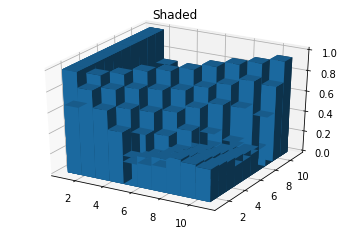

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.reshape(np.array([[i]*21 for i in range(1,11)]), (210))
Y = np.reshape(np.array([list(range(1,11)) * 21]), (210))
Z = np.reshape(v, (210,1))


top = np.reshape(v, (210))
bottom = np.zeros_like(top)
width = depth = 1

ax.bar3d(X, Y, bottom, width, depth, top, shade=True)
ax.set_title('Shaded');

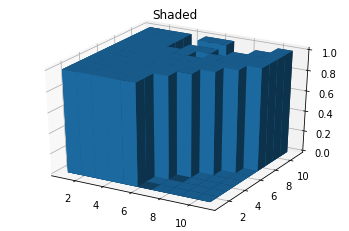

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.reshape(np.array([[i]*21 for i in range(1,11)]), (210))
Y = np.reshape(np.array([list(range(1,11)) * 21]), (210))

top = np.reshape(a, (210))
bottom = np.zeros_like(top)
width = depth = 1

ax.bar3d(X, Y, bottom, width, depth, top, shade=True)
ax.set_title('Shaded');

In [12]:
def sarsa_lambda(q, n, gamma, l):

    def update_step(q,e,td_error,i,j,k):
        q[i][j][k] += (1/n[i][j][k]) * td_error * e[i][j][k] if n[i][j][k] != 0 else 0
        e[i][j][k] *= l * gamma

    try:
        s = (draw_card(absolute=True), draw_card(absolute=True))
        a = glie_policy(q, s, ['hit', 'stick'], n)
        e = np.zeros((10,21,2))

        while True:
            s_, r, ts = step(s,a)

            a = 0 if a == 'hit' else 1
            e[s[0] - 1][s[1] - 1][a] += 1

            if ts:
                a_ = 0
                q_ = 0
            else:
                a_ = 0 if glie_policy(q, s_, ['hit','stick'], n) == 'hit' else 1
                q_ = q[s_[0]-1][s_[1] - 1][a_]

            td_error = r + gamma * q_ - q[s[0]-1][s[1]-1][a]
            n[s[0]-1][s[1]-1][a] += 1

            [[[update_step(q,e,td_error,i,j,k) for k in range(2)] for j in range(21)] for i in range(10)]

            if ts:
                break

            s = s_
            a = ['hit','stick'][a_]
    except Exception as e:
        print(s,a,r,s_)
        raise e

    tdq = q.copy()
    mse = np.sum([[[(tdq[i][j][k] - mcq[i][j][k]) ** 2 for k in range(2)] 
                   for j in range(21)] for i in range(10)])

    return mse

In [13]:
gamma = 1

mse = np.zeros((11,1000))

for l in range(0,11):
    q = np.zeros((10,21,2))
    n = np.zeros((10,21,2))
    for e in range(0,1000):
        mse[l][e] = sarsa_lambda(q,n,gamma,l/10)

In [14]:
dataset = []
[[dataset.append([i/10, j+1, mse[i][j]]) for j in range(0,1000)] for i in range(0,11)]

df = pd.DataFrame(dataset ,columns = ["lambda", "epoch", "mse"])
df["lambda"] = df["lambda"].astype('category')

In [15]:
df["lambda"].describe()

count     11000.0
unique       11.0
top           1.0
freq       1000.0
Name: lambda, dtype: float64

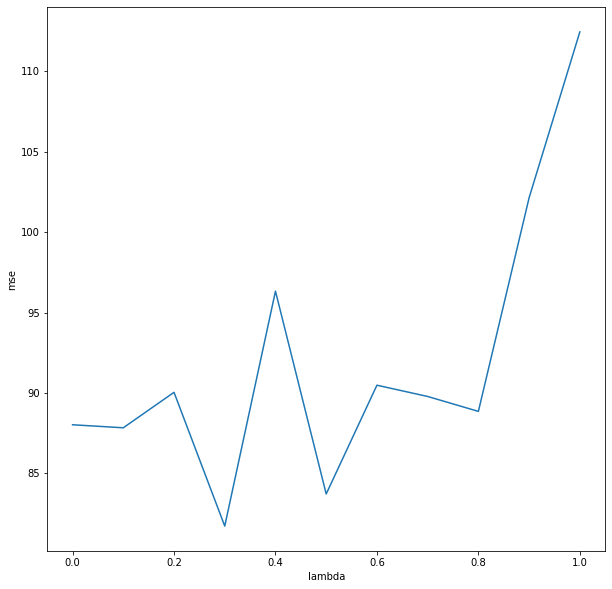

In [16]:
import seaborn as sns

fig = plt.figure(figsize=(10,10))
fdf = df[df["epoch"] == 1000]
sns.lineplot(x='lambda',y='mse', data=fdf)

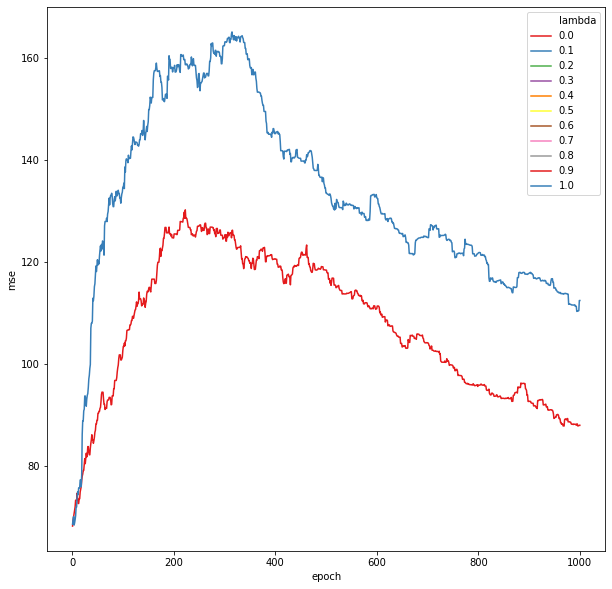

In [17]:
fig = plt.figure(figsize=(10,10))
fdf = df[df["lambda"].isin([0,1])]
sns.lineplot(x='epoch',y='mse',hue='lambda',palette=sns.color_palette("Set1", n_colors=11), data=fdf)

In [18]:
def get_feature_vector(s,a):
    d_set = [[1,4],[4,7],[7,10]]
    p_set = [[1,6],[4,9],[7,12],[10,15],[13,18],[16,21]] 
    a_set = ["hit", "stick"]
    x = [[[int((d[0] <= s[0] and d[1] >= s[0]) and (p[0] <= s[1] and p[1] >= s[1]) and (ax == a)) for ax in a_set]
         for p in p_set] for d in d_set]
    return np.reshape(np.array(x), (36))

In [19]:
get_feature_vector((10,17), "hit")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [20]:
np.dot(get_feature_vector((10,17), "hit"), np.random.rand(36))

1.1045284915502331

In [21]:
def glie_policy2(s, w, a):
    try:
        q_sa = [np.dot(get_feature_vector(s,ax), w) for ax in a]
        a_idx = np.argmax(q_sa)
        epsilon = 0.05
        a_prob = [epsilon/len(a)] * len(a)
        a_prob[a_idx] += 1 - epsilon
        return random.choice(a, p=a_prob)
    except Exception as e:
        print("glie2:", s)
        raise e
        
def sarsa_lambda(w, gamma, l):
    
    try:
        s = (draw_card(absolute=True), draw_card(absolute=True))
        a = glie_policy2(s, w, ['hit', 'stick'])
        
        fv = get_feature_vector(s,a)
        el = np.zeros_like(fv)

        while True:
            s_, r, ts = step(s,a)
            q = np.dot(fv, w)

            if ts:
                a_ = a
                q_ = q
            else:
                a_ = glie_policy2(s_, w, ['hit','stick'])
                q_ = np.dot(fv, w)
                
            td_error = r + gamma * (q_ - q)
            
            el = gamma * l * el + fv
            
            w += 0.01 * td_error * el

            if ts:
                break

            s = s_
            a = a_
            
    except Exception as e:
        print(s,a,r,s_)
        print(el)
        raise e

    faw = w.copy()
    mse = np.sum([[[(np.dot(get_feature_vector((i+1,j+1), ["hit", "stick"][k]), w) - mcq[i][j][k]) ** 2 
                    for k in range(2)] for j in range(21)] for i in range(10)])

    return mse

In [27]:
gamma = 1

mse = np.zeros((11,1000))

for l in range(0,11):
    w = np.random.rand(36)
    for e in range(0,1000):
        mse[l][e] = sarsa_lambda(w,gamma,l/10)

In [28]:
dataset = []
[[dataset.append([i/10, j+1, mse[i][j]]) for j in range(0,1000)] for i in range(0,11)]

df = pd.DataFrame(dataset ,columns = ["lambda", "epoch", "mse"])
df["lambda"] = df["lambda"].astype('category')

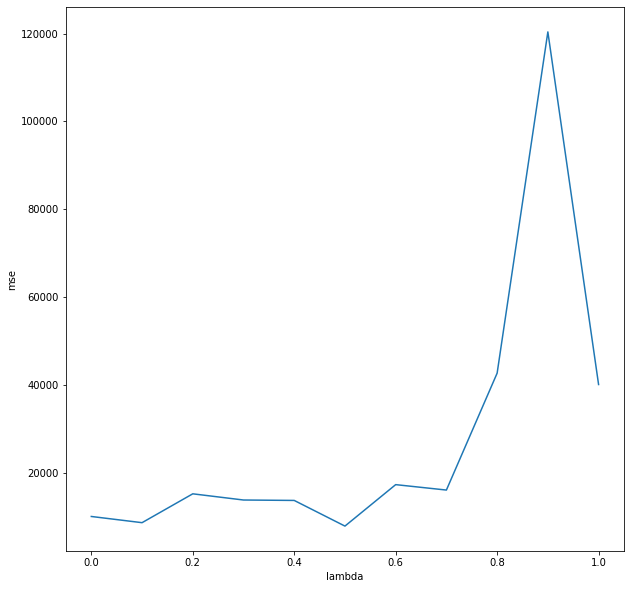

In [39]:
fig = plt.figure(figsize=(10,10))
fdf = df[df["epoch"] == 1000]
sns.lineplot(x='lambda',y='mse', data=fdf)

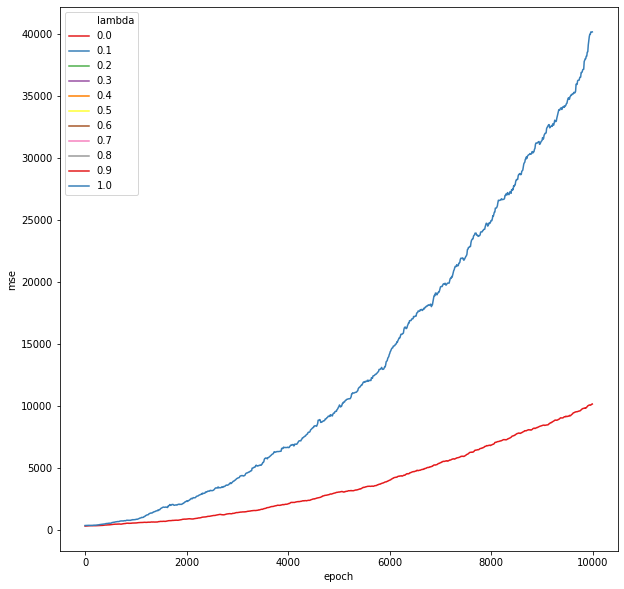

In [30]:
fig = plt.figure(figsize=(10,10))
fdf = df[df["lambda"].isin([0,1])]
sns.lineplot(x='epoch',y='mse',hue='lambda',palette=sns.color_palette("Set1", n_colors=11), data=fdf)